In [1]:
%load_ext autoreload
%autoreload 2
import os
import traceback
from dataset.station_dataset import GroundstationDataset
import matplotlib.pyplot as plt
from models.FCN import residual_FCN
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torchmetrics import MeanAbsoluteError, MeanSquaredError
import wandb
import xarray
from dataset.dataset import ImageDataset, SeviriDataset, valid_test_split, pickle_read
from dataset.normalization import MinMax, ZeroMinMax
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.utilities import rank_zero_only
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from models.ConvResNet_Jiang import ConvResNet, ConvResNet_batchnormMLP, ConvResNet_dropout, ConvResNet_inputCdropout, ConvResNet_BNdropout
from models.LightningModule import LitEstimator, LitEstimatorPoint
from tqdm import tqdm
from types import SimpleNamespace
from pathlib import Path

from train import get_dataloaders

In [2]:
config = {
        "batch_size": 2048,
        "patch_size": {
            "x": 15,
            "y": 15,
            "stride_x": 1,
            "stride_y": 1,
        },
        "x_vars": [
            "channel_1",
            "channel_2",
            "channel_3",
            "channel_4",
            "channel_5",
            "channel_6",
            "channel_7",
            "channel_8",
            "channel_9",
            "channel_10",
            "channel_11",
            "DEM",
        ],
        "y_vars": ["SIS",],
        "x_features": ["dayofyear", "lat", "lon", 'SZA', "AZI",],
        "transform": ZeroMinMax(),
        "target_transform": ZeroMinMax(),
        'max_epochs': 10,
        # Compute related
        'num_workers': 24,
        'ACCELERATOR': "gpu",
        'DEVICES': -1,
        'NUM_NODES': 32,
        'STRATEGY': "ddp",
        'PRECISION': "32",
        'EarlyStopping': {'patience':2},
        'ModelCheckpoint':{'every_n_epochs':1, 'save_top_k':1},
        'ckpt_fn': None, #'/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation_groundstation/pl86of1b/checkpoints/epoch=4-val_loss=0.01630.ckpt',
    }
config = SimpleNamespace(**config)

In [3]:
wandb_logger = WandbLogger(id='drvowqn4', project="SIS_point_estimation_groundstation", resume=True)


In [25]:

# download checkpoint locally (if not already cached)
artifact_dir = wandb_logger.download_artifact('krschuurman/SIS_point_estimation/model-4nbyae30:best', artifact_type="model")
print('artifact_dir:', artifact_dir)

wandb:   1 of 1 files downloaded.  


artifact_dir: /scratch/snx3000/kschuurm/irradiance_estimation/train/artifacts/model-4nbyae30:v2


In [4]:
# load checkpoint
# estimator = LitEstimatorPoint.load_from_checkpoint(Path(artifact_dir) / "model.ckpt")
estimator = LitEstimatorPoint.load_from_checkpoint('../train/SIS_point_estimation_groundstation/drvowqn4/checkpoints/epoch=0-val_loss=0.01659.ckpt')

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'metric' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['metric'])`.


In [5]:
train_dataloader, valid_dataloader = get_dataloaders(config)

sampler setup : 9.081 seconds


In [6]:
trainer =  Trainer(
        logger=wandb_logger,
        accelerator=config.ACCELERATOR,
        devices=config.DEVICES,
        max_epochs=config.max_epochs,
        precision=config.PRECISION,
        log_every_n_steps=500,
    )

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning-env/lib/python3. ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning-env/lib/python3. ...
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: krschuurman. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/numpy/lib/function_base.py:522: overflow encountered in cast
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1198: overflow encountered in square


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     MeanAbsoluteError     │    52.058860778808594     │
│     MeanSquaredError      │     6464.66162109375      │
│          R2Score          │            nan            │
│         val_loss          │   0.019250456243753433    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.019250456243753433,
  'MeanSquaredError': 6464.66162109375,
  'MeanAbsoluteError': 52.058860778808594,
  'R2Score': nan}]

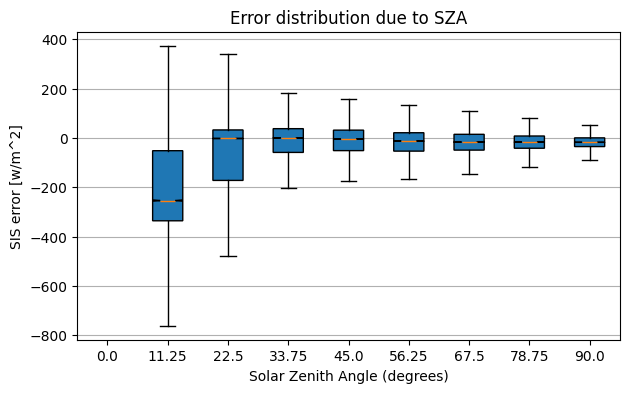

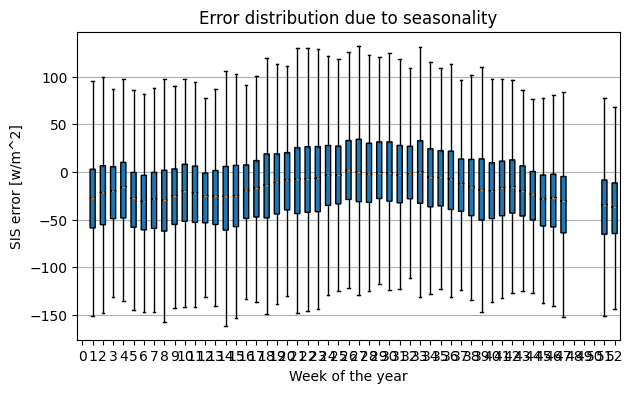

In [7]:
trainer.validate(estimator, valid_dataloader)

In [8]:
wandb_logger.experiment.finish()

wandb: WARNING Ensure read and write access to run files dir: ./wandb/run-20240423_164844-drvowqn4/files, control this via the WANDB_DIR env var. See https://docs.wandb.ai/guides/track/environment-variables


MeanAbsoluteError,▁
MeanSquaredError,▁
epoch,▁
trainer/global_step,▁
val_loss,▁
MeanAbsoluteError,52.05886
MeanSquaredError,6464.66162
R2Score,nan
epoch,0
loss_epoch,0.01551
loss_step,0.01515


In [27]:
estimator.zero_loss = MeanSquaredError()
estimator.lr = 0.00001
estimator.configure_optimizers()

{'optimizer': AdamW (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 1e-05
     maximize: False
     weight_decay: 0.01
 ),
 'lr_scheduler': {'scheduler': <torch.optim.lr_scheduler.ReduceLROnPlateau at 0x15538cf541f0>,
  'monitor': 'val_loss',
  'frequency': 1}}

In [28]:
trainer =  Trainer(
        logger=wandb_logger,
        accelerator=config.ACCELERATOR,
        devices=config.DEVICES,
        precision=config.PRECISION,
        log_every_n_steps=500,
        max_epochs=10,
        limit_train_batches=.1,
        limit_val_batches=.1,
    )

val_dataloader  = DataLoader(valid_dataloader.dataset, shuffle=True, batch_size=None, num_workers=config.num_workers)

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning-env/lib/python3. ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(estimator, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,)

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory ./SIS_point_estimation/4nbyae30/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                    | Params
-------------------------------------------------------------
0 | model            | ConvResNet_batchnormMLP | 4.2 M 
1 | metric           | MeanSquaredError        | 0     
2 | other_metrics    | MetricCollection        | 0     
3 | parameter_metric | MeanSquaredError        | 0     
4 | zero_loss        | MeanSquaredError        | 0     
-------------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.761    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/scratch/snx3000/kschuurm/lightning-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1198: overflow encountered in square


Training: |          | 0/? [00:00<?, ?it/s]

In [21]:
wandb_logger.experiment.finish()

wandb: WARNING Ensure read and write access to run files dir: ./wandb/run-20240422_183622-4nbyae30/files, control this via the WANDB_DIR env var. See https://docs.wandb.ai/guides/track/environment-variables


epoch,▁▁▁
loss_step,█▁█
trainer/global_step,▁▅█
zero_loss,▇█▁
MeanAbsoluteError,46.85812
MeanSquaredError,5814.65527
R2Score,0.91972
epoch,0
loss_epoch,0.01066
loss_step,0.00725
trainer/global_step,1499
